<img src="https://raw.githubusercontent.com/harmonize-tools/socio4health/main/docs/source/_static/image.png" alt="image info" height="100" width="100"/>


# Hands-on with socio4health: effects of hydrometeorologigcal hazards and urbanization on dengue risk in Brazil 



**Run the tutorial via free cloud platforms:**  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/harmonize-tools/socio4health/HEAD?urlpath=%2Fdoc%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2Fexample_brazil.ipynb) <a target="_blank" href="https://colab.research.google.com/github/harmonize-tools/socio4health/blob/main/docs/source/notebooks/example_brazil.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook provides a real-world example of how to use **socio4health** to **retrieve**, **harmonize** and **analyze** **socioeconomic and demographic**  variables, such as the level of urbanization and access to water supply in Brazil, to recreate the dataset used in the publication *Combined effects of hydrometeorological hazards and urbanisation on dengue risk in Brazil: a spatiotemporal modelling study* by Lowe et al., published in *The Lancet Planetary Health* in 2021 ([DOI](https://doi.org/10.1016/S2542-5196(20)30292-8)). The study evaluated how the association between hydrometeorological events and **dengue** risk varies with these variables. This tutorial assumes an **intermediate** or **advanced** understanding of **Python** and data manipulation.

## Setting up the environment

To run this notebook, you need to have the following prerequisites:

- **Python 3.10+**

Additionally, you need to install the `socio4health` and `pandas` package, which can be done using ``pip``:



In [1]:
!pip install socio4health pandas -q

In case you want to run this notebook in **Google Colab**, you also need to run the following command to use your files stored in **Google Drive**:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Libraries

To perform the data extraction, the `socio4health` library provides the `Extractor` class for data extraction, and the `Harmonizer` class for data harmonization of the retrieved date. `pandas` will be used for data manipulation. Additionally, we will use some utility functions from the `socio4health.utils.harmonizer_utils` module to **standardize** and **translate** the dictionary.


In [2]:
import re
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from socio4health import Extractor
from socio4health.harmonizer import Harmonizer
from socio4health.utils import harmonizer_utils, extractor_utils

## 1. Load and standardize the dictionary
To harmonize the data, provide a dictionary that describes the variables in the dataset. The study retrieved data from the 2010 census, from Instituto Brasileiro de Geografia e Estatística (**IBGE**). The dictionary for the census data can be found [here](https://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_Gerais_da_Amostra/Microdados/Documentacao.zip). Follow the steps in the tutorial ["How to Create a Raw Dictionary for Data Harmonization"](https://harmonize-tools.github.io/socio4health/dictionary.html) to create a raw dictionary in Excel format.

This dictionary must be standardized and translated to English. The `socio4health.utils.harmonizer_utils` module provides utility functions to perform these tasks. Additionally, the `socio4health.utils.extractor_utils` module provides utility functions to parse fixed-width file (FWF) dictionaries, which is the format used in the **IBGE** census data.


In [3]:
raw_dic = pd.read_excel("raw_dictionary_br_2010.xlsx")
dic=harmonizer_utils.s4h_standardize_dict(raw_dic)
colnames, colspecs =extractor_utils.s4h_parse_fwf_dict(dic)


c:\Users\Juan\anaconda3\envs\social4health\Lib\site-packages\socio4health\utils\harmonizer_utils.py:98: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_process_group, include_groups=True)\


This is how the standardized dictionary looks:

In [4]:
dic

variable_name                                           question  \
0          V0402            a responsabilidade pelo domicílio é de:   
1          V0209                abastecimento de água, canalização:   
2          V0208                      abastecimento de água, forma:   
3          V6210                               adequação da moradia   
4          V0301  alguma pessoa que morava com você(s) estava mo...   
..           ...                                                ...   
71         V0214                             televisão, existência:   
72         V4002                                   tipo de espécie:   
73         V0001                              unidade da federação:   
74         V2011                        valor do aluguel (em reais)   
75         V0011                                 área de ponderação   

    description                                              value  \
0           NaN                                      1.0; 2.0; 9.0   
1           NaN                                      1.0; 2.0; 3.0   
2           NaN  1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0   
3           NaN                                      1.0; 2.0; 3.0   
4           NaN                                           1.0; 2.0   
..          ...                                                ...   
71          NaN                                           1.0; 2.0   
72          NaN  11.0; 12.0; 13.0; 14.0; 15.0; 51.0; 52.0; 53.0...   
73          NaN  11.0; 12.0; 13.0; 14.0; 15.0; 16.0; 17.0; 21.0...   
74          NaN                                                NaN   
75          NaN                                                NaN   

   initial_position  final_position  size  dec type  \
0             107.0           107.0   1.0  NaN    C   
1              90.0            90.0   1.0  NaN    C   
2              88.0            89.0   2.0  NaN    C   
3             144.0           144.0   1.0  NaN    C   
4             104.0           104.0   1.0  NaN    C   
..              ...             ...   ...  ...  ...   
71             95.0            95.0   1.0  NaN    C   
72             56.0            57.0   2.0  NaN  C\n   
73              1.0             2.0   2.0  NaN    A   
74             59.0            64.0   6.0  NaN    N   
75              8.0            20.0  13.0  NaN    A   

                                     possible_answers  
0     apenas um morador; mais de um morador; ignorado  
1   sim, em pelo menos um cômodo; sim, só na propr...  
2   rede geral de distribuição; poço ou nascente n...  
3                 adequada; semi-adequada; inadequada  
4                                            sim; não  
..                                                ...  
71                                           sim; não  
72  casa; casa de vila ou em condomínio; apartamen...  
73  rondônia; acre; amazonas; roraima; pará; amapá...  
74                                                NaN  
75                                                NaN  

[76 rows x 10 columns]

The classification model used in this tutorial is a **BERT model** fine-tuned for the task of classifying survey questions into categories. You can use your own model by providing the path to the model in the `MODEL_PATH` parameter of the `harmonizer_utils.s4h_classify_rows` function.

In [5]:
dic = harmonizer_utils.s4h_translate_column(dic, "question", language="en")
dic = harmonizer_utils.s4h_translate_column(dic, "description", language="en")
dic = harmonizer_utils.s4h_translate_column(dic, "possible_answers", language="en")
dic = harmonizer_utils.s4h_classify_rows(dic, "question_en", "description_en", "possible_answers_en",
                                        new_column_name="category",
                                        MODEL_PATH="files/bert_finetuned_classifier")
dic

question translated
description translated
possible_answers translated


Device set to use cpu


variable_name                                           question  \
0          V0402            a responsabilidade pelo domicílio é de:   
1          V0209                abastecimento de água, canalização:   
2          V0208                      abastecimento de água, forma:   
3          V6210                               adequação da moradia   
4          V0301  alguma pessoa que morava com você(s) estava mo...   
..           ...                                                ...   
71         V0214                             televisão, existência:   
72         V4002                                   tipo de espécie:   
73         V0001                              unidade da federação:   
74         V2011                        valor do aluguel (em reais)   
75         V0011                                 área de ponderação   

    description                                              value  \
0           NaN                                      1.0; 2.0; 9.0   
1           NaN                                      1.0; 2.0; 3.0   
2           NaN  1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0; 9.0; 10.0   
3           NaN                                      1.0; 2.0; 3.0   
4           NaN                                           1.0; 2.0   
..          ...                                                ...   
71          NaN                                           1.0; 2.0   
72          NaN  11.0; 12.0; 13.0; 14.0; 15.0; 51.0; 52.0; 53.0...   
73          NaN  11.0; 12.0; 13.0; 14.0; 15.0; 16.0; 17.0; 21.0...   
74          NaN                                                NaN   
75          NaN                                                NaN   

   initial_position  final_position  size  dec type  \
0             107.0           107.0   1.0  NaN    C   
1              90.0            90.0   1.0  NaN    C   
2              88.0            89.0   2.0  NaN    C   
3             144.0           144.0   1.0  NaN    C   
4             104.0           104.0   1.0  NaN    C   
..              ...             ...   ...  ...  ...   
71             95.0            95.0   1.0  NaN    C   
72             56.0            57.0   2.0  NaN  C\n   
73              1.0             2.0   2.0  NaN    A   
74             59.0            64.0   6.0  NaN    N   
75              8.0            20.0  13.0  NaN    A   

                                     possible_answers  \
0     apenas um morador; mais de um morador; ignorado   
1   sim, em pelo menos um cômodo; sim, só na propr...   
2   rede geral de distribuição; poço ou nascente n...   
3                 adequada; semi-adequada; inadequada   
4                                            sim; não   
..                                                ...   
71                                           sim; não   
72  casa; casa de vila ou em condomínio; apartamen...   
73  rondônia; acre; amazonas; roraima; pará; amapá...   
74                                                NaN   
75                                                NaN   

                                          question_en  description_en  \
0                     Responsibility for the home is:             NaN   
1                             water supply, plumbing:             NaN   
2                                 water supply, form:             NaN   
3                              suitability of housing             NaN   
4   someone who lived with you was living in anoth...             NaN   
..                                                ...             ...   
71                             television, existence:             NaN   
72                                      species type:             NaN   
73                                   federation unit:             NaN   
74                            rental value (in reais)             NaN   
75                                     weighting area             NaN   

                                  possible_answers_en        category  
0   just one r

## 2. Extract data from Brazil Census 2010

To extract data, use the `Extractor` class from the `socio4health` library. As in the publication, extract the Brazil Census 2010 dataset from the Brazilian Institute of Geography and Statistics (**IBGE**) website or from a local copy. The dataset is available [here](https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados).

The `Extractor` class requires the following parameters:
- `input_path`: The `URL` or local path to the data source.
- `down_ext`: A list of file extensions to download. This can include `.txt`,`.zip`, etc.
- `output_path`: The local path where the extracted data will be saved.
- `key_words`: A list of keywords to filter the files to be downloaded. In this case, a regular expression is used to select only the files with a `.zip` extension that contain uppercase letters in their names.
- `depth`: The depth of the directory structure to traverse when downloading files. A depth of `0` means only the files in the specified directory will be downloaded.
- `is_fwf`: A boolean indicating whether the files are in fixed-width format (FWF). In this case, the files are in FWF format, so this parameter is set to `True`.
- `colnames`: A list of column names for the FWF files, extracted from the standardized dictionary.
- `colspecs`: A list of tuples indicating the start and end positions of each column in the FWF files, extracted from the standardized dictionary.


In [6]:
bra_online_extractor = Extractor(input_path="https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados",
                                 down_ext=['.txt','.zip'],
                                 output_path="../../../../Socio4HealthData/input/IBGE_2010_",
                                 key_words=["^[A-Z]+\.zip$"],
                                 depth=0, is_fwf=True, colnames=colnames, colspecs=colspecs)
bra_Censo_2010 = bra_online_extractor.s4h_extract()

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Juan\AppData\Local\Temp\ipykernel_16272\2648841082.py:4: SyntaxWarning: invalid escape sequence '\.'
  key_words=["^[A-Z]+\.zip$"],
2025-10-23 16:24:42,329 - INFO - ----------------------
2025-10-23 16:24:42,329 - INFO - Starting data extraction...
2025-10-23 16:24:42,329 - INFO - Extracting data in online mode...
2025-10-23 16:24:42,329 - INFO - Scraping URL: https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados with depth 0
2025-10-23 16:26:48,218 - INFO - Spider completed successfully for URL: https://www.ibge.gov.br/estatisticas/sociais/saude/9662-censo-demografico-2010.html?=&t=microdados
2025-10-23 16:26:48,302 - INFO - Downloading files to: ../../../../Socio4HealthData/input/IBGE_2010_
2025-10-23 16:29:46,630 - INFO - Processing (depth 0): RO.zip
2025-10-23 16:29:47,213 - INFO - Extracted: 908775b3_RO_Dom11.txt
2025-10-23 16:29

## 3. Harmonize the data

Use the Harmonizer class from the **socio4health** library to harmonize the data. First, set the similarity threshold to `0.9`, meaning that only variables with a similarity score of `0.9` or higher will be considered for harmonization. Next, use the `s4h_vertical_merge` method to merge the dataframes vertically.

In [7]:
har = Harmonizer()
har.similarity_threshold = 0.9
dfs = har.s4h_vertical_merge(bra_Censo_2010)

Grouping DataFrames:   0%|          | 0/84 [00:00<?, ?it/s]

Merging groups: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


After merging the dataframes, set the dictionary and the categories of interest. In this case, we are interested in the `"Business"` category. Then, use the `s4h_data_selector` method to filter the dataframes based on the dictionary, categories, and a key column (in this case `'V0001'`, which represents the state code). The `s4h_data_selector` method returns a list of **filtered dataframes**.

In [8]:
har.dict_df = dic
har.categories = ["Business"]
har.key_col = 'V0001'
filtered_ddfs = har.s4h_data_selector(dfs)

2025-10-23 16:48:03,039 - WARNING - key_col or key_val not defined, row-wise size will not be reduced


In [9]:
len(filtered_ddfs)

1

In [10]:
filtered_ddfs[0].compute()

V0001 V0208 V0301      V2012 V0222 V0701 V0211 V0207 V0212 M0201  ...  \
0         11    05     0  011000308     3     0     3     0     3  <NA>  ...   
1         11    01     0  001000030     1     0     5     0     0  <NA>  ...   
2         11    00     0  003000025     2     0     3     0     3  <NA>  ...   
3         11    02     0  002000074     1     0     6     0     7  <NA>  ...   
4         11    02     0  002000095     1     0     2     0     5  <NA>  ...   
...      ...   ...   ...        ...   ...   ...   ...   ...   ...   ...  ...   
600041    35    01     0  002000035     1     0     3     0     3  <NA>  ...   
600042    35    02     0  004000094     2     0     2     0     5  <NA>  ...   
600043    35    01     0  011000072     2     0     1     0     7  <NA>  ...   
600044    35    06     0  003000189     2     0     0     0     0  <NA>  ...   
600045    35    01     0  202000067     3     0     0     0     0  <NA>  ...   

       V0202 V0221 V0401 V6531 V6532 V6530    V6529 V0206 V1005   V2011  
0          6     0    30  <NA>  <NA>   532  0838202     0  <NA>  001001  
1          1     0    10  <NA>  <NA>   043  0949157     0  <NA>  001001  
2          0     0    10  <NA>  <NA>   251  0893810     0  <NA>  001001  
3          0     0    20  <NA>  <NA>   187  1250810     0  <NA>  001001  
4          3     0    30  <NA>  <NA>   185  1132514     0  <NA>  001001  
...      ...   ...   ...   ...   ...   ...      ...   ...   ...     ...  
600041     8     0    20  <NA>  <NA>   796  0596965     0  <NA>  001001  
600042     5     0    20  <NA>  <NA>   683  0400864     0  <NA>  001001  
600043     7     0    40  <NA>  <NA>   832  0788861     0  <NA>  001001  
600044     3     0    10  <NA>  <NA>   017  0995361     0  <NA>  001001  
600045     0     0    20  <NA>  <NA>   683  0692803     0  <NA>  001001  

[32004235 rows x 46 columns]

Finally, we can perform some **analysis** on the harmonized data. In this case, we will calculate the total population by state (`V0001`) using the variable `V0401`, which represents the total population in each census tract. We will then create a horizontal bar plot to visualize the population distribution across states using `matplotlib`.

In [11]:
ddf = filtered_ddfs[0][["V0001", "V0401"]]

ddf = ddf.assign(
    V0001 = ddf["V0001"].astype("category"),
    V0401 = dd.to_numeric(ddf["V0401"], errors="coerce").astype("float64").fillna(0.0)
).categorize(columns=["V0001"])

pop = ddf.groupby("V0001")["V0401"].sum(split_out=8).compute()

c:\Users\Juan\anaconda3\envs\social4health\Lib\site-packages\dask\dataframe\dask_expr\_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


In [17]:
pop = pop[pop>0]
row = dic.loc[dic["variable_name"]=="V0001", ["value","possible_answers"]].iloc[0]

vals = [s for s in re.split(r"\s*;\s*", str(row["value"]).strip(" ;")) if s]
labs = [s for s in re.split(r"\s*;\s*", str(row["possible_answers"]).strip(" ;")) if s]

idx = pop.index
if pd.api.types.is_integer_dtype(idx):
    keys = [int(float(v)) for v in vals]
elif pd.api.types.is_float_dtype(idx):
    keys = [float(v) for v in vals]
else:
    keys = [str(int(float(v))) for v in vals]

if len(keys) != len(labs):
    raise ValueError(f"Misalignment: {len(keys)} codes vs {len(labs)} names")
code2name = dict(zip(keys, labs))

pop_named = pop.rename(index=code2name)


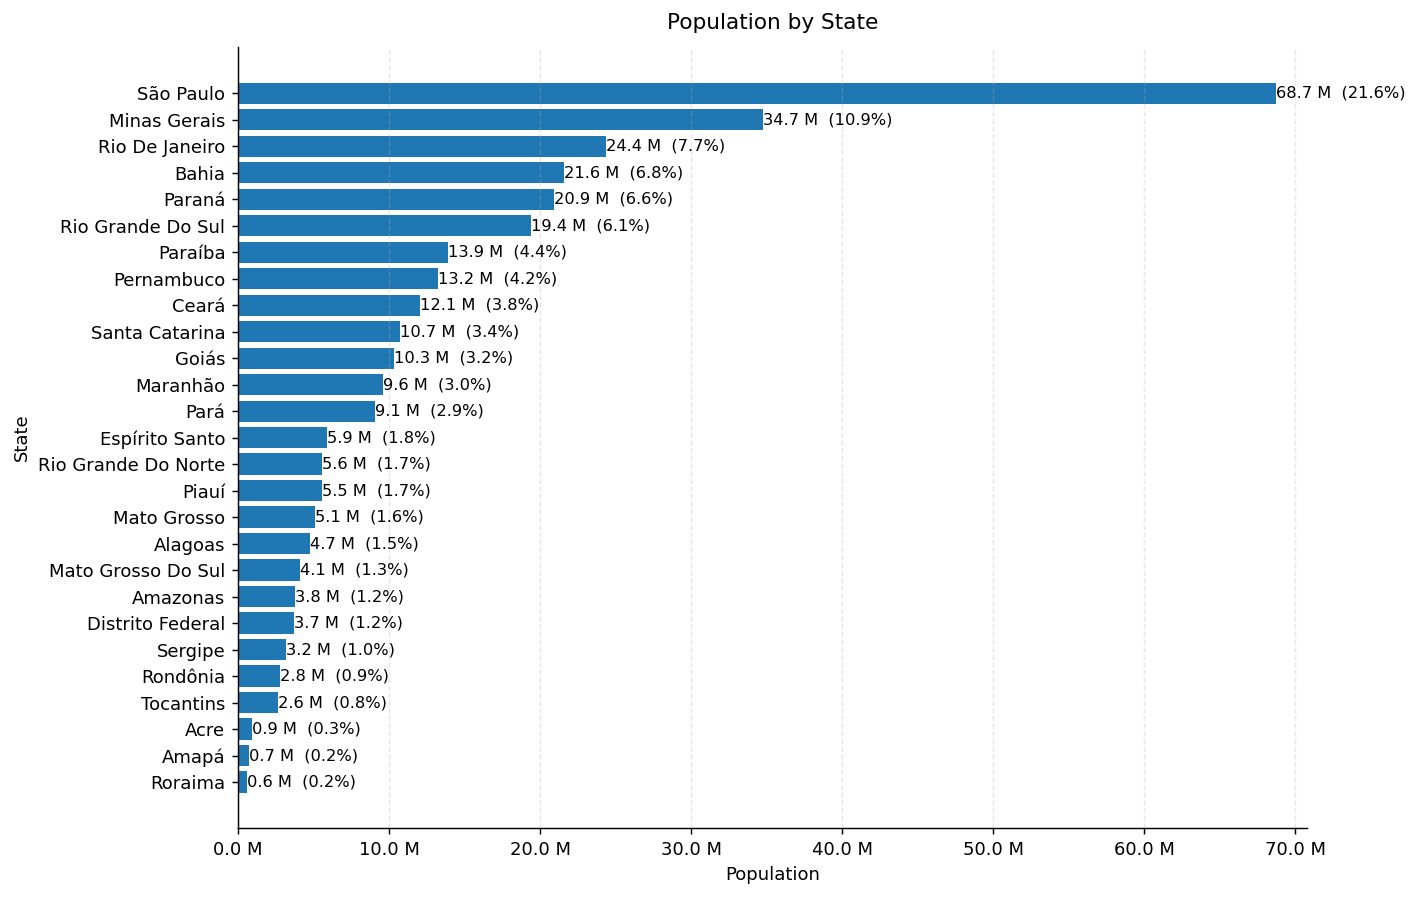

In [18]:
top = pop_named.sort_values()
top_titled = top.copy()
top_titled.index = [str(s).title() for s in top.index]

fig, ax = plt.subplots(figsize=(11,7), dpi=130)
ax.barh(top_titled.index, top_titled.values)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title(f"Population by State", pad=10)
ax.set_xlabel("Population")
ax.set_ylabel("State")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x/1e6:.1f} M"))

total = pop_named.sum()
for i, v in enumerate(top_titled.values):
    ax.text(v, i, f"{v/1e6:.1f} M  ({v/total:.1%})", va="center", ha="left", fontsize=9)

ax.grid(axis="x", linestyle="--", alpha=0.3)
plt.margins(x=0.03)
plt.tight_layout()
plt.show()